<!--HEADER-->
*Notas de aula de Modelagem Matemática - 2021/1 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2021p1/notas_de_aula/04.04-Exemplos_ajuste_naolinear.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/julia-env-for-binder-2021p1?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252Fmodelagem_matematica%26branch%3Dmodmat2021p1%26urlpath%3Dtree%252Fmodelagem_matematica%252Fnotas_de_aula/04.04-Exemplos_ajuste_naolinear.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2021p1/notas_de_aula/slides/04.04-Exemplos_ajuste_naolinear.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 4.3. Mínimos quadrados não-linear](04.03-Minimos_quadrados_nao_linear.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [5. Erros, incertezas ->](05.00-Erros_incertezas_quantificacao.ipynb)

---


# Exemplos de ajuste não-linear de parâmetros

* Há vários pacotes de otimização disponíveis no julia

* Aqui, vamos usar apenas o `LsqFit` e o `Optim`:

* [JuliaNLSolvers/LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl): implementação do algoritmo de Levenberg-Maquardt especificamente para mínimos quadrados não-linear.

* [JuliaNLSolvers/Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl): implementação de vários algoritmos de otimização, com qualquer função-objetivo, não necessariamente mínimos quadrados.

### Outros pacotes

* [JuliaNLSolvers/LineSearches.jl](https://github.com/JuliaNLSolvers/LineSearches.jl): implementação de vários algoritmos do tipo *busca linear* *(linesearch)* (como o gradiente descendente, etc.).

* [jump-dev/JuMP.jl](https://github.com/jump-dev/JuMP.jl): para processos de modelagem mais complexos, com uma série de macros para construir um modelo para a otimização, e com interface para vários pacotes (em julia ou não) de otimização.

* [matthieugomez/LeastSquaresOptim.jl](https://github.com/matthieugomez/LeastSquaresOptim.jl): também para a resolução de problemas de mínimos quadrados não lineares, via Levenberg-Marquardt ou Dogleg.

* [robertfeldt/BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl): para otimizacões globais com métodos heurísticos/estocásticos, livres de derivada.

* [JuliaNLSolvers/NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl/): Para resolver sistemas de equações.

* Veja mais em [JuliaOpt](https://www.juliaopt.org/packages/)

In [1]:
using Plots
using Random
using LsqFit
using Optim

## Exemplo Michaelis-Menten de reação enzimática

* Michaelis-Menten é um modelo para a taxa de reação enzimática (velocidade) $\nu$, dado por
$$ \nu = \frac{\nu_m t}{K_M + t}
$$

* Onde $t$ é a variável temporal, $\nu_m$ é uma taxa máxima de velodidade, e $K_M$ é um parâmetro de saturação da reação.

* $\nu_m$ e $K_M$ são os parâmetros e, como de costume, denotamo-os por $\beta=(\nu_m, K_m)$.

In [2]:
function model(t, β)
    ν_m = β[1]
    K_M = β[2]
    v = (ν_m .* t) ./ (K_M .+ t)
    return v
end

ν_m = 0.3
K_M = 0.5
β = [ν_m K_M]
nothing

## Obtendo uma amostra de dados

* Perturbamos os dados exatos para simular imprecisões na coleta de dados

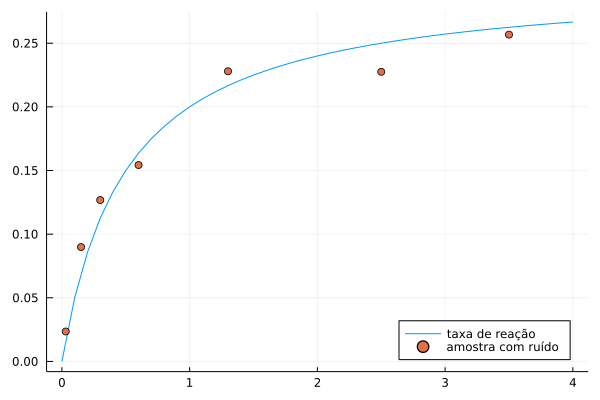

In [3]:
data_t = [0.03, 0.15, 0.3, 0.6, 1.3, 2.5, 3.5]
data_v = model(data_t, β) .+ 0.05*(rand(MersenneTwister(321), length(data_t)) .- 0.5)
plot(0:0.1:4, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")

### Ajuste dos dados via LsqFit

* Otimizando com o `curve_fit` do `LsqFit`

* É necessário dar um "chute" inicial para os parâmetros.

In [4]:
β₀ = [0.5, 0.5]
fit = curve_fit(model, data_t, data_v, β₀)
β_fit = fit.param

2-element Vector{Float64}:
 0.27385430554237405
 0.3573547044880839

### Visualizando o resultado

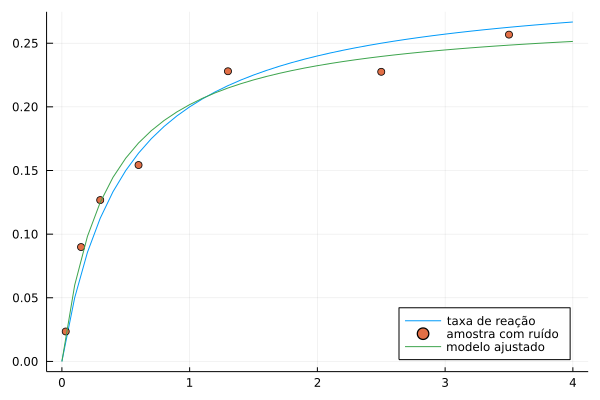

In [5]:
plot(0:0.1:4, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(0:0.1:4, t -> model(t, β_fit), label="modelo ajustado", legend=:bottomright)

### Ajuste dos dados via Optim

* Aqui, usamos o método de gradiente descendente do `Optim`.

* No `Optim`, precisamos explicitar a função custo.

* Lembremos que queremos ajustar os parâmetros, ou seja, precisamos minimizar o custo em relação aos parâmetros.

* Novamente, a função custo é da soma dos quadrados dos residuos, ou erro quadrático.

In [6]:
custo(β) = sum(abs2,data_v - model(data_t,β))

custo (generic function with 1 method)

In [7]:
resultado = optimize(custo, β₀, GradientDescent())

 * Status: success

 * Candidate solution
    Final objective value:     7.751687e-04

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 7.31e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.05e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.55e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.01e-13 ≰ 0.0e+00
    |g(x)|                 = 7.10e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    72
    f(x) calls:    220
    ∇f(x) calls:   220


In [8]:
β_optim = Optim.minimizer(resultado)

2-element Vector{Float64}:
 0.2738543232663811
 0.3573548106304591

### Visualizando o resultado

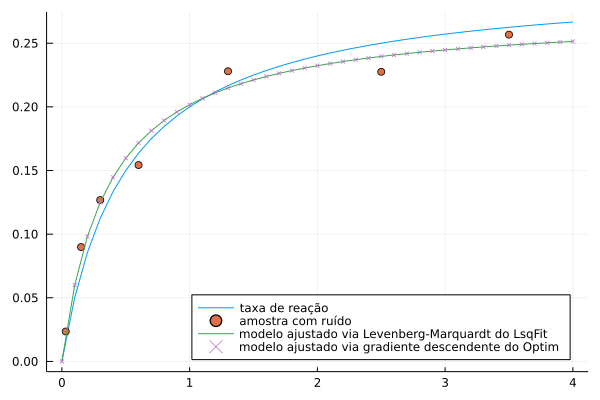

In [9]:
plot(0:0.1:4, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(0:0.1:4, t -> model(t, β_fit), label="modelo ajustado via Levenberg-Marquardt do LsqFit", legend=:bottomright)
plot!(0:0.1:4, t -> model(t, β_optim), seriestype=:scatter, markershape=:xcross, markersize=2,
        label="modelo ajustado via gradiente descendente do Optim", legend=:bottomright)

## Dados espúrios *(outliers)*

* É comum, por dificuldades no processo de amostragem ou de tratamento dos dados, termos dados "espúrios", i.e. claramente fora do padrão.

* São, também, denominados de *outliers*.

* Podemos tentar filtrar os dados espúrios da amostra usando técnicas de estatística.

* E/Ou podemos reduzir o impacto dos dados espúrios com funções de custo ligeiramente modificadas.

### Dados contaminados

* Vamos modificar a amostra anterior substituindo um dos dados por um dado espúrio.

In [10]:
data_v_esp = copy(data_v)
data_v_esp[5] += 0.15
nothing

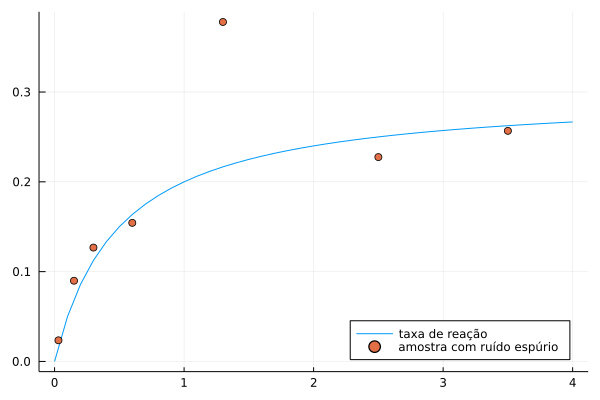

In [11]:
plot(0:0.1:4, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v_esp, seriestype=:scatter, label="amostra com ruído espúrio")

### Ajuste

In [12]:
custo_esp(β) = sum(abs2,data_v_esp - model(data_t,β))
resultado_esp = optimize(custo_esp, β₀, GradientDescent())
β_optim_esp = Optim.minimizer(resultado_esp)

2-element Vector{Float64}:
 0.3150999020168445
 0.3607669696333052

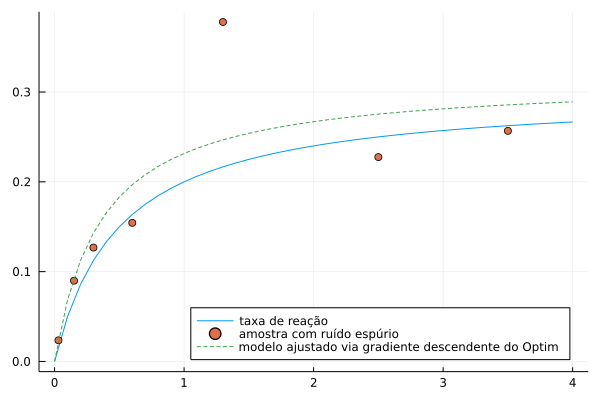

In [13]:
plot(0:0.1:4, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v_esp, seriestype=:scatter, label="amostra com ruído espúrio")
plot!(0:0.1:4, t -> model(t, β_optim_esp), linestyle=:dash,
        label="modelo ajustado via gradiente descendente do Optim", legend=:bottomright)

### Funções de custo modificadas

* A ideia, aqui, é modificar a função quadrática de custo para uma em que resíduos relativamente grandes causem menos influência.

* Vários tipos de modificações costumam ser usadas.

In [14]:
mods_custo = Dict(
    :linear => (r -> @. r),
    :soft_l1 => (r -> @. 2*((1 + abs(r))^(1/2) - 1)),
    :huber => (r -> @. min(r, 2*((1 + abs(r))^(1/2) - 1))),
    :cauchy => (r -> @. log.(1 .+ abs(r))),
    :arctan => (r -> @. atan(r))
)

Dict{Symbol, Function} with 5 entries:
  :cauchy  => #22
  :arctan  => #23
  :soft_l1 => #20
  :huber   => #21
  :linear  => #19

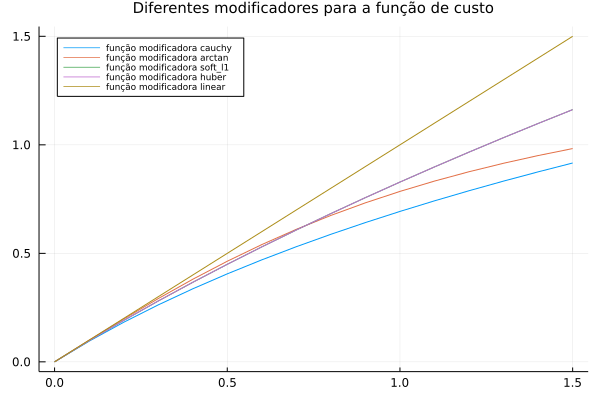

In [15]:
plot(title="Diferentes modificadores para a função de custo", titlefont=10)
for (k,func) in mods_custo
    plot!(0:0.1:1.5, func, label="função modificadora $k", 
        legendfont=6, legend=:topleft, subplot=1)
end
plot!()

In [16]:
sq(e) = sum(abs2, e)

sq (generic function with 1 method)

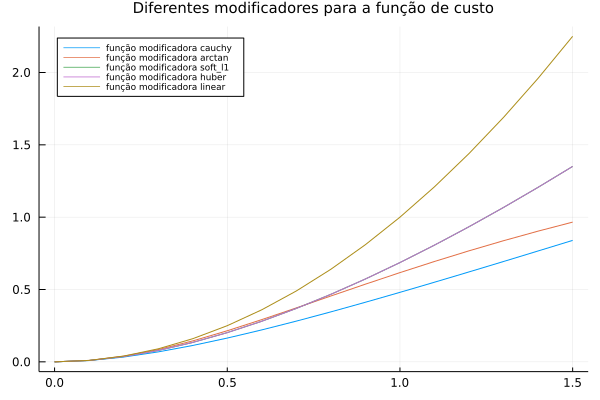

In [17]:
plot(title="Diferentes modificadores para a função de custo", titlefont=10)
for (k,func) in mods_custo
    plot!(0:0.1:1.5, sq∘func, label="função modificadora $k", 
        legendfont=6, legend=:topleft, subplot=1)
end
plot!()

### Ampliando o efeito dos modificadores

* O efeito dos diferents modificadores pode ser amplificado com uma função de espalhamento:
$$ s \mapsto \lambda s
$$

In [18]:
λ(s) = 20*s

λ (generic function with 1 method)

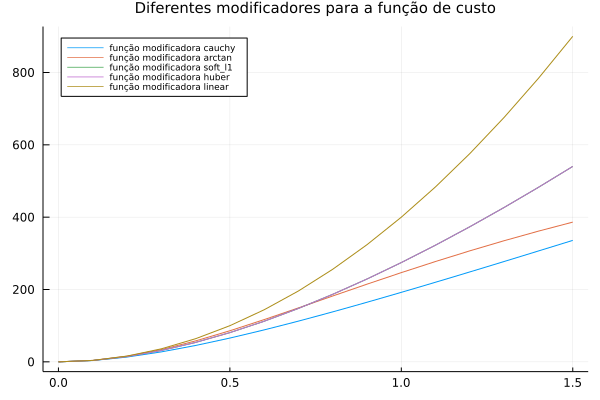

In [19]:
plot(title="Diferentes modificadores para a função de custo", titlefont=10)
for (k,func) in mods_custo
    plot!(0:0.1:1.5, sq∘λ∘func, label="função modificadora $k", 
        legendfont=6, legend=:topleft, subplot=1)
end
plot!()

### Função de custo modificada

* Assim, a função de custo é a composição 
$$ \text{função quadrática} \circ \text{modificador} \circ \text{espalhamento} \circ \text{resíduos}.
$$

### Fazendo os ajustes

In [20]:
residuos_esp(β) = data_v_esp - model(data_t,β)
resultados_esp = 
    Dict(k => optimize(sq∘func∘λ∘residuos_esp, β₀, GradientDescent())
        for (k,func) in mods_custo
        )
nothing

### Visualizando os resultados

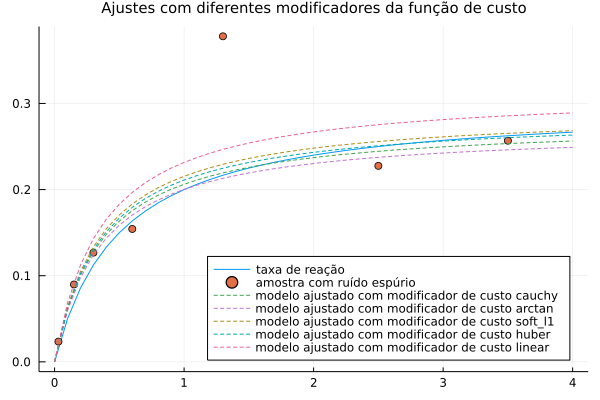

In [21]:
plot(0:0.1:4, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v_esp, seriestype=:scatter, label="amostra com ruído espúrio")
for k in keys(mods_custo)
    plot!(0:0.1:4, t -> model(t, Optim.minimizer(resultados_esp[k])), linestyle=:dash,
        label="modelo ajustado com modificador de custo $k", legend=:bottomright)
end
plot!(title="Ajustes com diferentes modificadores da função de custo", titlefont=10)

## Exercícios

1. Refaça os exemplos do caderno sobre **Modelos redutíveis ao caso linear nos parâmetros e aplicações** como problemas de otimização não-linear, sem usar as mudanças de variáveis feitas lá.

<!--NAVIGATOR-->

---
[<- 4.3. Mínimos quadrados não-linear](04.03-Minimos_quadrados_nao_linear.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [5. Erros, incertezas ->](05.00-Erros_incertezas_quantificacao.ipynb)